# Lab 1 – Pima Diabetes: KNIME ↔ Python Companion Notebook

This notebook mirrors the main blocks of the KNIME workflow:

1. **Data Preparation** (yellow block)
2. **Decision Tree (Baseline) Model** (green block)
3. **Logistic Regression Model and Feature Importances** (blue block)

The goal is to reproduce in Python what happens in KNIME, and to show how models and predictions can be shared between KNIME and Python.


> **Note**  
> If you run this notebook in a fresh environment (e.g. Google Colab), you may need to install a few packages first. 


In [2]:
!pip install pandas scikit-learn pypmml matplotlib

  Using cached pypmml-1.5.8-py3-none-any.whl.metadata (8.2 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 58.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 68.1 MB/s  0:00:00
Using cached pypmml-1.5.8-py3-none-any.whl (14.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 64.5 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 7

The code below imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [28]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

try:
    from pypmml import Model as PMMLModel
except ImportError:
    PMMLModel = None

DATA_URLS = {
    "diabetes.csv": (
        "https://raw.githubusercontent.com/pvateekul/digitalhealth-ai2025/"
        "main/code/Class01_IntroML/diabetes.csv"
    ),
    "d-tree.pmml": (
        "https://raw.githubusercontent.com/pvateekul/digitalhealth-ai2025/"
        "main/code/Class01_IntroML/d-tree.pmml"
    ),
}


def resolve_data_path(filename: str) -> str:
    candidate_dirs = [".", "/content"]

    # 1) Try local copies first
    for base in candidate_dirs:
        path = os.path.join(base, filename)
        if os.path.exists(path):
            print(f"Using local file: {os.path.abspath(path)}")
            return path

    # 2) Otherwise download from GitHub raw
    url = DATA_URLS[filename]
    target_path = os.path.join(os.getcwd(), filename)
    os.makedirs(os.path.dirname(target_path), exist_ok=True)

    print(f"Downloading '{filename}' from:\n  {url}\ninto:\n  {target_path}")
    urllib.request.urlretrieve(url, target_path)

    print(f"Downloaded: {os.path.abspath(target_path)}")
    return target_path



def evaluate_classifier(y_true, y_pred, y_prob=None, positive_label=1, model_name="model"):
    y_true = pd.Series(y_true).astype(str)
    y_pred = pd.Series(y_pred).astype(str)
    pos = str(positive_label)

    print(f"\n=== Evaluation for {model_name} ===")
    print("Label distribution:")
    print("  y_true:")
    print(y_true.value_counts())
    print("\n  y_pred:")
    print(y_pred.value_counts())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=["0", pos])

    print(f"\nAccuracy: {acc:.3f}")
    print("\nConfusion matrix (rows=true, cols=pred) [0,1]:")
    print(cm)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

    auc = None
    if y_prob is not None:
        y_true01 = (y_true == pos).astype(int)
        auc = roc_auc_score(y_true01, y_prob)
        print(f"ROC AUC (class {pos} vs others): {auc:.3f}")
    else:
        print("\n[Info] ROC AUC not computed (no probability scores provided).")

    return {"accuracy": acc, "roc_auc": auc, "confusion_matrix": cm}

## 1) Data Preparation (matches yellow block)

This section corresponds to:

- **CSV Reader** – load `diabetes.csv`
- **Row Filter / Expression / Missing Value** – handle impossible values and impute missing values
- **Statistics** – basic exploration (we use `.describe()` and `value_counts()`)
- **Normalizer** – standardize numeric features (z-score)
- **Table Partitioner** – train/test split stratified by `Outcome`


In [29]:
csv_path = resolve_data_path(
    'diabetes.csv',
    )

df = pd.read_csv(csv_path)
print(df.shape)
df.head()

Using local file: /Users/theerapatkangsilalai/Documents/GitHub/digitalhealth-ai2025/code/Class01_IntroML/diabetes.csv
(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [30]:
target_col = 'Outcome'
df[target_col] = df[target_col].astype(int)
df[target_col].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [32]:
feature_cols = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
]

df_for_impute = df.copy()
cols_with_zero_as_nan = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_zero_as_nan:
    df_for_impute[col] = df_for_impute[col].replace(0, np.nan)

df_for_impute[cols_with_zero_as_nan].isna().sum()


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [33]:
df_imputed = df_for_impute.copy()
for col in cols_with_zero_as_nan:
    mean_val = df_imputed[col].mean()
    df_imputed[col] = df_imputed[col].fillna(mean_val)

df_imputed[cols_with_zero_as_nan].isna().sum()


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    df_imputed[feature_cols], df_imputed[target_col], test_size=0.3, random_state=42, stratify=df_imputed[target_col]
)

X_train.shape, X_test.shape

((537, 8), (231, 8))

## 2) Decision Tree Model– matches green block

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

tree_pred_test = tree_clf.predict(X_test)
tree_prob_test = tree_clf.predict_proba(X_test)[:, 1]

tree_metrics = evaluate_classifier(
    y_true=y_test,
    y_pred=tree_pred_test,
    y_prob=tree_prob_test,
    positive_label=1,
    model_name="Decision Tree (Python, baseline)",
)


=== Evaluation for Decision Tree (Python, baseline) ===
Label distribution:
  y_true:
Outcome
0    150
1     81
Name: count, dtype: int64

  y_pred:
0    149
1     82
Name: count, dtype: int64

Accuracy: 0.710

Confusion matrix (rows=true, cols=pred) [0,1]:
[[116  34]
 [ 33  48]]

Classification report:
              precision    recall  f1-score   support

           0      0.779     0.773     0.776       150
           1      0.585     0.593     0.589        81

    accuracy                          0.710       231
   macro avg      0.682     0.683     0.682       231
weighted avg      0.711     0.710     0.710       231

ROC AUC (class 1 vs others): 0.683


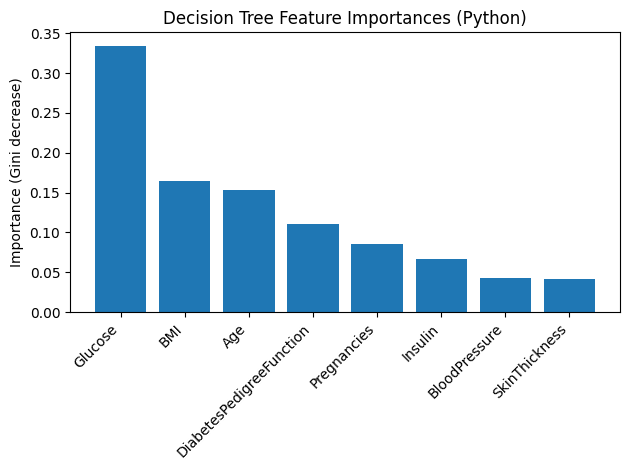

,feature,importance
1,Glucose,0.334287
5,BMI,0.164788
7,Age,0.152754
6,DiabetesPedigreeFunction,0.111133
0,Pregnancies,0.086098
4,Insulin,0.066462
2,BloodPressure,0.043099
3,SkinThickness,0.041378


In [37]:
importances = tree_clf.feature_importances_
fi_df = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values(
    "importance", ascending=False
)

plt.figure()
plt.bar(fi_df["feature"], fi_df["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance (Gini decrease)")
plt.title("Decision Tree Feature Importances (Python)")
plt.tight_layout()
plt.show()

fi_df


### Use Decision Tree PMML exported from KNIME

This part corresponds to the **PMML Writer** + **PMML Reader** + **Decision Tree Predictor** nodes.

Please make sure that the **d-tree.pmml** is uploaded/saved next to the notebook.iypnb.


In [ ]:
tree_pmml_path = resolve_data_path('d-tree.pmml')
tree_pmml_model = PMMLModel.load(tree_pmml_path)

tree_pmml_pred = tree_pmml_model.predict(X_test)
tree_pmml_pred_with_y = pd.concat(
    [y_test.reset_index(drop=True), tree_pmml_pred.reset_index(drop=True)],
    axis=1,
)

print(tree_pmml_pred_with_y.columns.tolist())

pred_col = (
    "predicted_Outcome"
    if "predicted_Outcome" in tree_pmml_pred_with_y.columns
    else tree_pmml_pred_with_y.columns[0]
)
prob1_col = None
for c in tree_pmml_pred_with_y.columns:
    if "prob" in c.lower() and ("(1)" in c or c.endswith("1")):
        prob1_col = c
        break

tree_pmml_metrics = evaluate_classifier(
    y_true=tree_pmml_pred_with_y["Outcome"],
    y_pred=tree_pmml_pred_with_y[pred_col],
    y_prob=(
        tree_pmml_pred_with_y[prob1_col]
        if prob1_col is not None
        else None
    ),
    positive_label=1,
    model_name="Decision Tree (KNIME PMML in Python)",
)


Using local file: /Users/theerapatkangsilalai/Documents/GitHub/digitalhealth-ai2025/code/Class01_IntroML/d-tree.pmml
['Outcome', 'predicted_Outcome', 'probability', 'probability_1', 'probability_0', 'node_id']

=== Evaluation for Decision Tree (KNIME PMML in Python) ===
Label distribution:
  y_true:
Outcome
0    150
1     81
Name: count, dtype: int64

  y_pred:
predicted_Outcome
0    231
Name: count, dtype: int64

Accuracy: 0.649

Confusion matrix (rows=true, cols=pred) [0,1]:
[[150   0]
 [ 81   0]]

Classification report:
              precision    recall  f1-score   support

           0      0.649     1.000     0.787       150
           1      0.000     0.000     0.000        81

    accuracy                          0.649       231
   macro avg      0.325     0.500     0.394       231
weighted avg      0.422     0.649     0.511       231

ROC AUC (class 1 vs others): 0.500


## 3) Decision Tree and Feature Importances – matches blue block


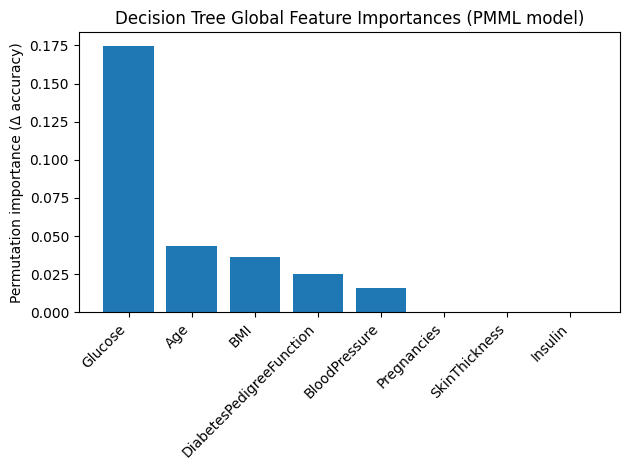

,feature,importance
1,Glucose,1.748698e-01
7,Age,4.322917e-02
5,BMI,3.652344e-02
6,DiabetesPedigreeFunction,2.480469e-02
2,BloodPressure,1.601562e-02
0,Pregnancies,1.110223e-16
3,SkinThickness,1.110223e-16
4,Insulin,1.110223e-16


In [42]:
class PMMLTreeWrapper:
    def __init__(self, pmml_model, feature_names):
        self.pmml_model = pmml_model
        self.feature_names = feature_names

    def predict(self, X):
        """
        X: numpy array or DataFrame.
        Returns predicted labels as strings.
        """
        X_df = pd.DataFrame(X, columns=self.feature_names)
        preds = self.pmml_model.predict(X_df)
        return preds["predicted_Outcome"].astype(str).values

X_all = df_imputed[feature_cols].to_numpy()
y_all = df_imputed["Outcome"].astype(str).to_numpy()

wrapped_tree = PMMLTreeWrapper(tree_pmml_model, feature_cols)

def permutation_importance_pmml(
    estimator,
    X,
    y,
    feature_names,
    n_repeats=20,
    random_state=2026,
):
    rng = np.random.RandomState(random_state)

    base_pred = estimator.predict(X)
    base_score = accuracy_score(y, base_pred)

    importances = []
    for j in range(X.shape[1]):
        scores_j = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            perm_idx = rng.permutation(X.shape[0])
            X_perm[:, j] = X_perm[perm_idx, j] 

            y_perm_pred = estimator.predict(X_perm)
            scores_j.append(accuracy_score(y, y_perm_pred))

        mean_perm_score = np.mean(scores_j)
        importances.append(base_score - mean_perm_score)

    importances = np.array(importances)

    df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).sort_values("importance", ascending=False)

    return df


tree_imp_df = permutation_importance_pmml(
    wrapped_tree,
    X_all,
    y_all,
    feature_cols,
    n_repeats=20,
    random_state=2026,
)

plt.figure()
plt.bar(tree_imp_df["feature"], tree_imp_df["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Permutation importance (Δ accuracy)")
plt.title("Decision Tree Global Feature Importances (PMML model)")
plt.tight_layout()
plt.show()

tree_imp_df